In [2]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import astropy.units as u
import random
import pandas as pd
import copy
import json
import numba
import math
import pickle

from textwrap import fill
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.coordinates import search_around_sky
from matplotlib.patches import Rectangle
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from astropy.coordinates import angular_separation
import astropy.units as u
from astropy.table import join
from collections import Counter


from Constantes import SELECTED_COLUMNS_Xamin, SELECTED_COLUMNS_input_clusters, SELECTED_COLUMNS_input_AGN
from Constantes import VOCAB_SIZE, PAD_TOKEN, SEP_TOKEN, CLS_TOKEN, SEP_AMAS, SEP_AGN, NOMBRE_TOKENS_SPECIAUX
from Constantes import BATCH_SIZE, D_MODEL, NUM_HEADS, NUM_LAYERS, name_dir
from Constantes import name_dir

################################################################################
#                                                                              #
#                             Constantes utilisées                             #
#                                                                              #
################################################################################

Nombre de colonnes SELECTED_COLUMNS_Xamin: 5
Nombre de colonnes SELECTED_COLUMNS_input_clusters: 2
Nombre de colonnes SELECTED_COLUMNS_input_AGN: 2

Nombre de colonnes use_log_scale_Xamin: 5
Nombre de colonnes use_log_scale_input_clusters: 2
Nombre de colonnes use_log_scale_input_AGN: 2


In [3]:
with open(f'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Catalog/sequence_veritas_test_0-500000.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(f'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Catalog/sequence_divinatio_test_0-500000.pkl', 'rb') as f:
    gen_seq = pickle.load(f)

X_test = np.array(X_test)
gen_seq = np.array(gen_seq)

print(f"Nombre de sequences de test: {len(X_test)}")
print(f"len(X_test[0]) = {len(X_test[0])}")

print(f"Nombre de sequences de gen: {len(gen_seq)}")
print(f"len(gen_seq[0]) = {len(gen_seq[0])}\n")

/tmp/ipykernel_884644/259773770.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  X_test = pickle.load(f)
/tmp/ipykernel_884644/259773770.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, u

Nombre de sequences de test: 500001
len(X_test[0]) = 28
Nombre de sequences de gen: 500001
len(gen_seq[0]) = 28



In [4]:
#////////// Load Configuration /////////
with open(f"/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Catalog/constantes_du_modele.json", 'r') as f:
    config = json.load(f)

MAX_SOURCES  = config["MAX_SOURCES"]
MAX_CLUSTERS = config["MAX_CLUSTERS"]
MAX_AGN = config["MAX_AGN"]

print("┌───────────────────────────────┐")
print("│  MODEL CONFIGURATION          │")
print("├───────────────────────────────┤")
for key, value in config.items():
    print(f"│ {key.ljust(15)}: {str(value).rjust(10)}   │")
print("└───────────────────────────────┘")

┌───────────────────────────────┐
│  MODEL CONFIGURATION          │
├───────────────────────────────┤
│ VOCAB_SIZE     :       1029   │
│ PAD_TOKEN      :       1024   │
│ SEP_TOKEN      :       1025   │
│ CLS_TOKEN      :       1026   │
│ SEP_AMAS       :       1027   │
│ SEP_AGN        :       1028   │
│ NOMBRE_TOKENS_SPECIAUX:          5   │
│ MAX_SOURCES    :          2   │
│ MAX_CLUSTERS   :          2   │
│ MAX_AGN        :          5   │
└───────────────────────────────┘


In [11]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])


[1026 1024  484  511  511  224 1024 1024 1024 1024 1024 1027 1024 1024
 1024 1024 1028  502  520 1024 1024 1024 1024 1024 1024 1024 1024 1025]
[1026 1024  484  511  511  224 1024 1024 1024 1024 1024 1027 1024 1024
 1024 1024 1028 1024 1025 1024 1024 1024 1024 1024 1024 1024 1024 1025]


In [12]:
def plot_sequence(sequence, num_fenetre, x_center=512, y_center=512):
    # Extraire les composants en supposant la structure:
    # [CLS_TOKEN, Xamin, SEP_AMAS, amas, SEP_AGN, AGN, SEP_TOKEN]
    sequence = sequence.tolist()

    # Indices des séparateurs
    '''    
    try:
        sep_amas_idx = sequence.index(SEP_AMAS)
        sep_agn_idx = sequence.index(SEP_AGN)
        sep_end_idx = sequence.index(SEP_TOKEN)
    except ValueError:
        print("Séparateurs manquants dans la séquence.")
        return'''

    # Extraire les sous-parties
    sep_amas_idx = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + 1
    sep_agn_idx = sep_amas_idx + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS +1
    xamin_part = sequence[1:sep_amas_idx]
    amas_part = sequence[sep_amas_idx +1: sep_agn_idx]
    agn_part = sequence[sep_agn_idx + 1:-1]

    print(f"Partie Xamin: {xamin_part}")
    print(f"Partie Amas : {amas_part}")
    print(f"Partie AGN  : {agn_part}")
    
    plt.figure(figsize=(6, 6))

    # Plot Xamin
    compteur_xamin = 0
    for i in range(2, len(xamin_part), 5):
        x, y = xamin_part[i], xamin_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='o', facecolors='none', edgecolors='lightseagreen',
                        s=100, linewidths=1.5, label='Xamin' if compteur_xamin==0 else "")
            compteur_xamin += 1

    compteur_output_agn, compteur_output_amas = 0, 0
    # Plot amas (paires [x,y]) - carrés rouges vides
    for i in range(0, len(amas_part), 2):
        x, y = amas_part[i], amas_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='s', facecolors='none', edgecolors='red',
                      s=80, linewidths=1, label='Output Clusters' if compteur_output_amas==0 else "")
            compteur_output_amas += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un amas")

    # Plot AGN (paires [x,y]) - étoiles rouges vides
    for i in range(0, len(agn_part), 2):
        x, y = agn_part[i], agn_part[i+1]
        #if (x, y) != (1024, 1024):
        if (x != 1024 and y != 1024 ):
            plt.scatter(x, y, marker='*', facecolors='none', edgecolors='red',
                      s=140, linewidths=1, label='Output AGN' if compteur_output_agn==0 else "")
            compteur_output_agn += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un AGN")

    # Reste du code inchangé
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axvline(x=1024, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=1024, color='black', linestyle='--')

    plt.xlim(-100, 1124)
    plt.ylim(-110, 1124)
    plt.grid(True)
    plt.legend()
    plt.title(f"Visualisation de la fenêtre {num_fenetre}")

    # Ajout d'un texte d'information
    info_text = (f"Input Xamin: {compteur_xamin}\n"
                 f"Output AGN: {compteur_output_agn} Output Clusters: {compteur_output_amas}")
    plt.annotate(info_text, xy=(0.5, 0.02), xycoords='axes fraction',
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.show()

Veritas: [1026  556  714  511  511  102  449  389  857  394  248 1027  446  464
 1024 1024 1028  821  404 1024 1024 1024 1024 1024 1024 1024 1024 1025]

Devinatio: [1026  556  714  511  511  102  449  389  857  394  248 1027  511  486
  660  431 1028  511  486  505  511  511  511  511  511  528  511 1025]

Partie Xamin: [556, 714, 511, 511, 102, 449, 389, 857, 394, 248]
Partie Amas : [511, 486, 660, 431]
Partie AGN  : [511, 486, 505, 511, 511, 511, 511, 511, 528, 511]


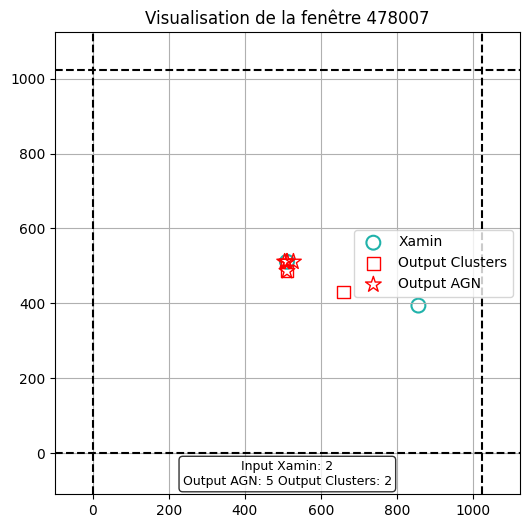

In [13]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(f"Veritas: {X_test[num_fenetre]}\n")
print(f"Devinatio: {gen_seq[num_fenetre]}\n")

plot_sequence(gen_seq[num_fenetre], num_fenetre)

In [14]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])

indice_debut_AMAS = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + 2
indice_fin_AMAS   = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS +1

print("\n\033[1mCatalogue AMAS:\033[0m")
print(X_test[num_fenetre,indice_debut_AMAS:indice_fin_AMAS+1])

indice_debut_AGN = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS + 3 
indice_fin_AGN   = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS + len(SELECTED_COLUMNS_input_AGN) * MAX_AGN + 2

print("\n\033[1mCatalogue AGN:\033[0m")
print(X_test[num_fenetre,indice_debut_AGN:indice_fin_AGN+1])

print("\n\033[1mCatalogue AMAS extrait par la fonction:\033[0m")
print(gen_seq[num_fenetre,indice_debut_AMAS:indice_fin_AMAS+1])

print("\n\033[1mCatalogue AGN extrait par la fonction:\033[0m")
print(gen_seq[num_fenetre,indice_debut_AGN:indice_fin_AGN+1])


[1026 1024  473  511  511  462  546  487  519   44  159 1027 1024 1024
 1024 1024 1028  514  494  514  494 1024 1024 1024 1024 1024 1024 1025]
[1026 1024  473  511  511  462  546  487  519   44  159 1027  511  473
  511  511 1028  511  511  511  511  511  511  511  511  511  511 1025]

Catalogue AMAS:
[1024 1024 1024 1024]

Catalogue AGN:
[ 514  494  514  494 1024 1024 1024 1024 1024 1024]

Catalogue AMAS extrait par la fonction:
[511 473 511 511]

Catalogue AGN extrait par la fonction:
[511 511 511 511 511 511 511 511 511 511]


In [ ]:
def plot_compare_sequence(true_sequence, sequence, num_fenetre, x_center=512, y_center=512):
    # Extraire les composants en supposant la structure:
    # [CLS_TOKEN, Xamin, SEP_AMAS, amas, SEP_AGN, AGN, SEP_TOKEN]
    sequence = sequence.tolist()

    # Indices des séparateurs
    '''    
    try:
        sep_amas_idx = sequence.index(SEP_AMAS)
        sep_agn_idx = sequence.index(SEP_AGN)
        sep_end_idx = sequence.index(SEP_TOKEN)
    except ValueError:
        print("Séparateurs manquants dans la séquence.")
        return'''

    # Extraire les sous-parties
    sep_amas_idx = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + 1
    sep_agn_idx = sep_amas_idx + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS +1
    
    xamin_part = sequence[1:sep_amas_idx]
    amas_part = sequence[sep_amas_idx +1: sep_agn_idx]
    agn_part = sequence[sep_agn_idx + 1:-1]

    amas_true_part = true_sequence[sep_amas_idx +1: sep_agn_idx]
    agn_true_part = true_sequence[sep_agn_idx + 1:-1]


    print(f"Partie Xamin: {xamin_part}")
    print(f"\nVeritas    : Amas {amas_true_part}")
    print(f"Devinatio  : Amas {amas_part}")
    print(f"\nVeritas    : AGN {agn_true_part}")
    print(f"Devinatio  : AGN {agn_part}")

    

    plt.figure(figsize=(6, 6))

    # Plot Xamin
    compteur_xamin = 0
    for i in range(2, len(xamin_part), 5):
        x, y = xamin_part[i], xamin_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='o', facecolors='none', edgecolors='lightseagreen',
                        s=100, linewidths=1.5, label='Xamin' if compteur_xamin==0 else "")
            compteur_xamin += 1

    compteur_input_agn, compteur_input_amas = 0, 0
    # Plot amas (paires [x,y]) - carrés violets vides
    for i in range(0, len(amas_true_part), 2):
        x, y = amas_true_part[i], amas_true_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='s', facecolors='none', edgecolors='purple',
                      s=80, linewidths=1, label='Input Clusters' if compteur_input_amas==0 else "")
            compteur_input_amas += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un amas")

    # Plot AGN (paires [x,y]) - étoiles violettes vides
    for i in range(0, len(agn_true_part), 2):
        x, y = agn_true_part[i], agn_true_part[i+1]
        #if (x, y) != (1024, 1024):
        if (x != 1024 and y != 1024 ):
            plt.scatter(x, y, marker='*', facecolors='none', edgecolors='purple',
                      s=140, linewidths=1, label='Input AGN' if compteur_input_agn==0 else "")
            compteur_input_agn += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un AGN")

    compteur_output_agn, compteur_output_amas = 0, 0
    # Plot amas (paires [x,y]) - carrés rouges vides
    for i in range(0, len(amas_part), 2):
        x, y = amas_part[i], amas_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='s', facecolors='none', edgecolors='red',
                      s=80, linewidths=1, label='Output Clusters' if compteur_output_amas==0 else "")
            compteur_output_amas += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un amas")

    # Plot AGN (paires [x,y]) - étoiles rouges vides
    for i in range(0, len(agn_part), 2):
        x, y = agn_part[i], agn_part[i+1]
        #if (x, y) != (1024, 1024):
        if (x != 1024 and y != 1024 ):
            plt.scatter(x, y, marker='*', facecolors='none', edgecolors='red',
                      s=140, linewidths=1, label='Output AGN' if compteur_output_agn==0 else "")
            compteur_output_agn += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un AGN")

    # Reste du code inchangé
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axvline(x=1024, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=1024, color='black', linestyle='--')

    plt.xlim(-100, 1124)
    plt.ylim(-110, 1124)
    plt.grid(True)
    plt.legend()
    plt.title(f"Visualisation de la fenêtre {num_fenetre}")

    # Ajout d'un texte d'information
    info_text = (f"Input Xamin: {compteur_xamin}\n"
                 f"Output AGN: {compteur_output_agn} Output Clusters: {compteur_output_amas}")
    plt.annotate(info_text, xy=(0.5, 0.02), xycoords='axes fraction',
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.show()

[1026  587  577  511  511  343 1024  506  386  842  176 1027 1024 1024
 1024 1024 1028  517  508  517  508 1024 1024 1024 1024 1024 1024 1025]
[1026  587  577  511  511  343 1024  506  386  842  176 1027  480  458
  694  458 1028  516  458  458  694  458  458  458  458  458  458 1025]
Partie Xamin: [587, 577, 511, 511, 343, 1024, 506, 386, 842, 176]

Veritas    : Amas [1024 1024 1024 1024]
Devinatio  : Amas [480, 458, 694, 458]

Veritas    : AGN [ 517  508  517  508 1024 1024 1024 1024 1024 1024]
Devinatio  : AGN [516, 458, 458, 694, 458, 458, 458, 458, 458, 458]


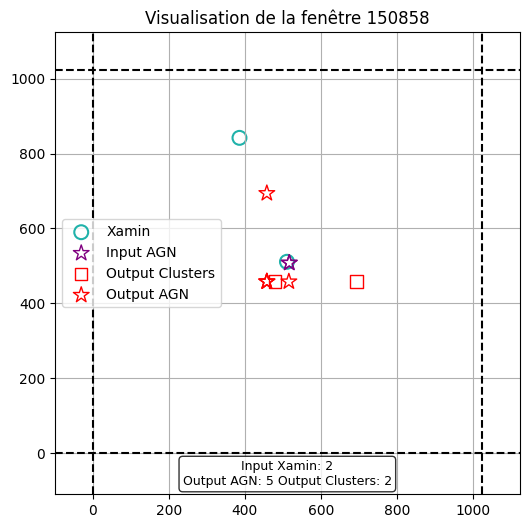

In [41]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])

plot_compare_sequence(X_test[num_fenetre] ,gen_seq[num_fenetre], num_fenetre)